# Vision Transformer (ViT)

## Configuration

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Imports

In [ ]:
from collections import defaultdict
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from tqdm import tqdm

import matplotlib.pyplot as plt

: 

In [9]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA TITAN V
NVIDIA TITAN V
NVIDIA TITAN RTX
NVIDIA TITAN RTX


Configuration

In [10]:
IMAGE_SIZE = 32
PATCH_SIZE = 4
NUM_CLASSES = 100

BATCH_SIZE = 128
NUM_WORKERS = 4
EPOCHS = 50
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-1

SAVE_PATH = './vit_weights.pkl'

In [32]:
DEVICE = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda:2


## Dataset

In [33]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [34]:
train_dset = datasets.CIFAR10(root='.', train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root='.', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [35]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                         num_workers=NUM_WORKERS)

## Model

In [36]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = nn.Sequential(*layers)
    
    def forward(self, x):
        return x + self.residual(x)

In [37]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, p_drop=0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p_drop)
        )

In [38]:
class SelfAttention(nn.Module):
    def __init__(self, dim, heads=8, p_drop=0.):
        super().__init__()
        self.heads = heads

        self.to_keys = nn.Linear(dim, dim)
        self.to_queries = nn.Linear(dim, dim)
        self.to_values = nn.Linear(dim, dim)
        self.unifyheads = nn.Linear(dim, dim)

        self.attn_drop = nn.Dropout(p_drop)
        self.resid_drop = nn.Dropout(p_drop)

    def forward(self, x):
        b, t, d = x.size()
        h, d_q = self.heads, d // self.heads

        keys = self.to_keys(x).view(b, t, h, d_q).transpose(1, 2) # move head forward to the batch dim
        queries = self.to_queries(x).view(b, t, h, d_q).transpose(1, 2)
        values = self.to_values(x).view(b, t, h, d_q).transpose(1, 2)

        att = queries @ keys.transpose(-2, -1)
        att = F.softmax(att * d_q**-0.5, dim=-1)
        att = self.attn_drop(att)
        
        out = att @ values
        out = out.transpose(1, 2).contiguous().view(b, t, d) # move head back
        out = self.unifyheads(out)
        out = self.resid_drop(out)
        return out

In [39]:
class Block(nn.Sequential):
    def __init__(self, dim, heads, mlp_dim, p_drop):
        super().__init__(
            Residual(nn.LayerNorm(dim), SelfAttention(dim, heads, p_drop)),
            Residual(nn.LayerNorm(dim), FeedForward(dim, mlp_dim, p_drop))
        )

In [40]:
class Transformer(nn.Sequential):
    def __init__(self, dim, depth, heads, mlp_dim, p_drop):
        layers = [Block(dim, heads, mlp_dim, p_drop) for _ in range(depth)]
        super().__init__(*layers)

In [41]:
class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, dim, channels=3, emb_p_drop=0.):
        super().__init__()
        self.patch_size = patch_size
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.pos_embedding = nn.Parameter(torch.Tensor(1, num_patches, dim))
        self.cls_token = nn.Parameter(torch.Tensor(1, 1, dim))
        self.emb_dropout = nn.Dropout(emb_p_drop)
    
    def forward(self, x):
        p = self.patch_size
        x = F.unfold(x, p, stride=p).transpose(-1, -2) # extract patches
        x = self.patch_to_embedding(x)
        x += self.pos_embedding # add positional embedding
        # add classification token
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.emb_dropout(x)
        return x

In [42]:
class TakeFirst(nn.Module):
    def forward(self, x):
        return x[:, 0]

In [43]:
class Head(nn.Sequential):
    def __init__(self, dim, hidden_dim, num_classes, p_drop=0.):
        super().__init__(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_dim, num_classes)
        )

In [44]:
class ViT(nn.Sequential):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3,
                 p_drop=0., emb_p_drop=0.):
        super().__init__(
            PatchEmbedding(image_size, patch_size, dim, channels, emb_p_drop),
            Transformer(dim, depth, heads, mlp_dim, p_drop),
            TakeFirst(),
            Head(dim, mlp_dim, num_classes, p_drop)
        )
        self.reset_parameters()
    
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.)
                nn.init.zeros_(m.bias)
            elif isinstance(m, PatchEmbedding):
                nn.init.normal_(m.pos_embedding, mean=0.0, std=0.02)
                nn.init.normal_(m.cls_token, mean=0.0, std=0.02)

In [54]:
model = ViT(IMAGE_SIZE, PATCH_SIZE, NUM_CLASSES, dim=512, depth=8, heads=8, mlp_dim=2048,
            p_drop=0.1, emb_p_drop = 0.1).to(DEVICE)

In [55]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 26,533,988


## Training

### Training loop

In [56]:
def show_or_save(fig, filename=None):
    if filename:
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)
        plt.close(fig)
    else:
        plt.show()

In [57]:
class History:
    def __init__(self):
        self.values = defaultdict(list)

    def append(self, key, value):
        self.values[key].append(value)

    def reset(self):
        for k in self.values.keys():
            self.values[k] = []

    def _plot(self, key, line_type='-', label=None):
        if not label: label=key
        xs = np.arange(1, len(self.values[key])+1)
        self.ax.plot(xs, self.values[key], line_type, label=label)

    def plot_train_val(self, key, x_is_batch=False, ylog=False, filename=None):
        fig = plt.figure()
        self.ax = fig.add_subplot(111)
        self._plot('train ' + key, '.-', 'train')
        self._plot('val ' + key, '.-', 'val')
        self.ax.legend()
        if ylog: self.ax.set_yscale('log')
        self.ax.set_xlabel('batch' if x_is_batch else 'epoch')
        self.ax.set_ylabel(key)
        show_or_save(fig, filename)

In [58]:
class Learner:
    def __init__(self, model, loss, optimizer, train_loader, val_loader, device,
                 epoch_scheduler=None, batch_scheduler=None):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.epoch_scheduler = epoch_scheduler
        self.batch_scheduler = batch_scheduler
        self.history = History()
    
    
    def iterate(self, loader, msg="", backward_pass=False):
        total_loss = 0.0
        num_samples = 0
        num_correct = 0
        
        pbar = tqdm(enumerate(loader), total=len(loader))
        for it, (X, Y) in pbar:
            X, Y = X.to(self.device), Y.to(self.device)
            Y_pred = self.model(X)
            batch_size = X.size(0)
            batch_loss = self.loss(Y_pred, Y)
            if backward_pass:
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                if self.batch_scheduler is not None:
                    self.batch_scheduler.step()
            
            Y_pred.detach_() # conserve memory
            labels_pred = torch.argmax(Y_pred, -1)
            total_loss += batch_size * batch_loss.item()
            num_correct += (labels_pred == Y).sum()
            num_samples += batch_size
            
            pbar.set_description("{} iter {}: loss {:.3f}, acc {:.3f}".format(
                msg, it, total_loss / num_samples, float(num_correct) / num_samples))
    
        avg_loss = total_loss / num_samples
        accuracy = float(num_correct) / num_samples
        return avg_loss, accuracy
    
    
    def train(self, msg):
        self.model.train()
        train_loss, train_acc = self.iterate(self.train_loader, msg + ' train:', backward_pass=True)
        self.history.append('train loss', train_loss)
        self.history.append('train acc', train_acc)

        
    def validate(self, msg):
        self.model.eval()
        with torch.no_grad():
            val_loss, val_acc = self.iterate(self.val_loader, msg + ' val:')
        self.history.append('val loss', val_loss)
        self.history.append('val acc', val_acc)


    def fit(self, epochs):
        for e in range(epochs):
            msg = f'epoch {e+1}/{epochs}'
            self.train(msg)
            self.validate(msg)
            if self.epoch_scheduler is not None:
                self.epoch_scheduler.step()

### Start training

In [59]:
loss = nn.CrossEntropyLoss()

In [60]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [61]:
learner = Learner(model, loss, optimizer, train_loader, val_loader, DEVICE)

In [62]:
learner.batch_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                                        steps_per_epoch=len(train_loader),
                                                        epochs=EPOCHS)

In [63]:
learner.fit(EPOCHS)

epoch 1/50 train: iter 390: loss 2.276, acc 0.196: 100%|██████████| 391/391 [00:58<00:00,  6.73it/s]
epoch 1/50 val: iter 78: loss 2.089, acc 0.221: 100%|██████████| 79/79 [00:04<00:00, 19.62it/s]
epoch 2/50 train: iter 390: loss 1.871, acc 0.290: 100%|██████████| 391/391 [00:57<00:00,  6.77it/s]
epoch 2/50 val: iter 78: loss 1.738, acc 0.349: 100%|██████████| 79/79 [00:04<00:00, 19.56it/s]
epoch 3/50 train: iter 390: loss 1.726, acc 0.352: 100%|██████████| 391/391 [00:58<00:00,  6.69it/s]
epoch 3/50 val: iter 78: loss 1.583, acc 0.408: 100%|██████████| 79/79 [00:04<00:00, 19.37it/s]
epoch 4/50 train: iter 390: loss 1.614, acc 0.404: 100%|██████████| 391/391 [00:58<00:00,  6.63it/s]
epoch 4/50 val: iter 78: loss 1.545, acc 0.436: 100%|██████████| 79/79 [00:04<00:00, 19.22it/s]
epoch 5/50 train: iter 390: loss 1.533, acc 0.439: 100%|██████████| 391/391 [00:59<00:00,  6.61it/s]
epoch 5/50 val: iter 78: loss 1.485, acc 0.466: 100%|██████████| 79/79 [00:04<00:00, 19.13it/s]
epoch 6/50 trai

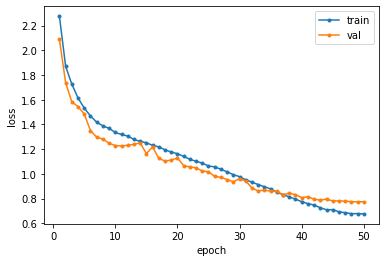

In [64]:
learner.history.plot_train_val('loss')

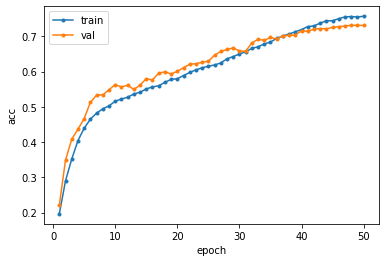

In [65]:
learner.history.plot_train_val('acc')